In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open("eos_result/tmp_result_13b.json", "r") as f:
    result = json.load(f)
# with open("eos_result/tmp_result.json", "r") as f:
#     result1 = json.load(f)
# for key in result:
#     result[key] += result1[key]
eos_postions = result["eos_poss"]
eos_probabilities = result["eos_probabilities"]
df = pd.DataFrame(eos_postions).T
df_prob = pd.DataFrame(eos_probabilities).T
# result = json.load(open("eos_result/eos_result_batch.json"))
# result1 = json.load(open("eos_result/tmp_result.json"))
# for key in result:
#     result[key] += result1[key]
# eos_postions = result["eos_poss"]
# eos_probabilities = result["eos_probabilities"]
# df = pd.DataFrame(eos_postions).T
# df_prob = pd.DataFrame(eos_probabilities).T

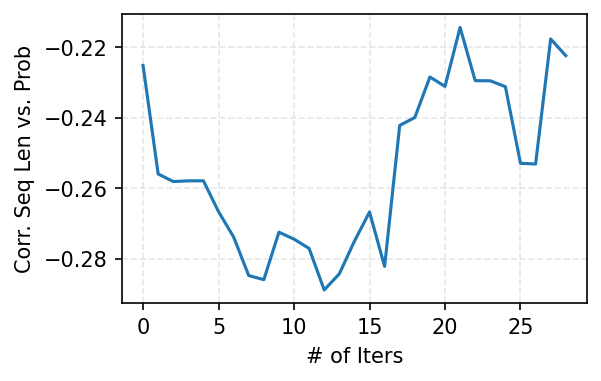

In [3]:
corrs = []
ratio = []
count = df.describe().T["count"]
for i in range(1, 30):
    df_eos_prob_count = df_prob[:i].describe().T[["count", "mean"]]
    df_eos_prob_count["count"] = count - i
    df_eos_prob_count = df_eos_prob_count[df_eos_prob_count["count"] > 0]
    ratio.append(df_eos_prob_count["count"]/df_eos_prob_count['mean'])
    corrs.append(df_eos_prob_count.corr(method="pearson").loc["mean", "count"])



plt.figure(figsize=(4, 2.5), dpi=150)
sns.lineplot(corrs)
plt.xlabel("# of Iters")
plt.ylabel("Corr. Seq Len vs. Prob")
plt.grid(alpha=0.3, linestyle="--")
# plt.savefig("fig/eos_corr.pdf")

In [111]:
ns = (-np.log(prob_mean['max'])+24).astype(int)
ns

0      28
1      31
2      34
3      32
4      24
       ..
134    29
135    24
136    26
137    28
138    29
Name: max, Length: 139, dtype: int64

In [91]:
output_count

,count
0,190.0
1,104.0
2,626.0
3,363.0
4,1.0
...,...
134,465.0
135,1.0
136,19.0
137,23.0


<Axes: ylabel='Proportion'>

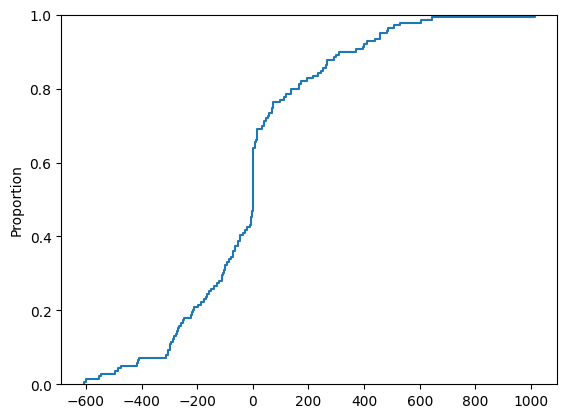

In [112]:
output_count = df_prob.describe().T[["count"]]
prob_mean = df_prob[:15].describe().T[["max"]]
ns = (-np.log(prob_mean['max'])+25).astype(int)
values = 1-prob_mean
predicted_seq_lens = []
for i in range(len(prob_mean)):
    value = values.values[i]
    n=ns.values[i]
    predicted_seq_lens.append(value*((1+n*value**(n+1)-(n+1)*(value**n))/(((1-value)**2))))
predicted_seq_len = pd.DataFrame(predicted_seq_lens,columns=['max'])
compared_result = output_count['count']-predicted_seq_len['max']
sns.ecdfplot(compared_result)

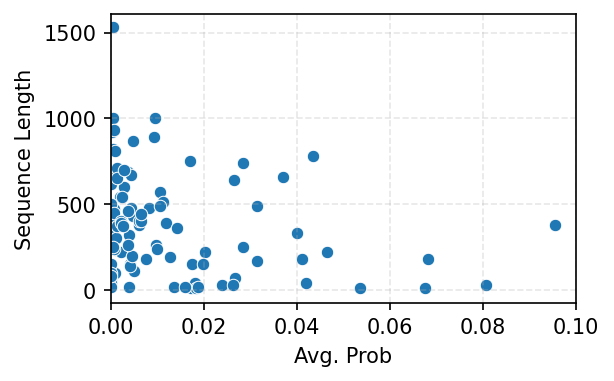

In [4]:
output_count = df_prob.describe().T[["count"]]
prob_mean = df_prob[:15].describe().T[["max"]]
prob_std = df_prob[:15].describe().T[["std"]]
output_count=output_count//10*10
count_prob_mean = pd.DataFrame({"mean": prob_mean.values.flatten(), "count": output_count.values.flatten(), "std": prob_std.values.flatten()})
count_prob_mean['cov']=count_prob_mean['mean']
plt.figure(figsize=(4,2.5), dpi=150)
sns.scatterplot(data=count_prob_mean, x="mean",y="count")
plt.xlim(0,0.1)
plt.xlabel("Avg. Prob")
plt.ylabel("Sequence Length")
plt.grid(alpha=0.3, linestyle='--')

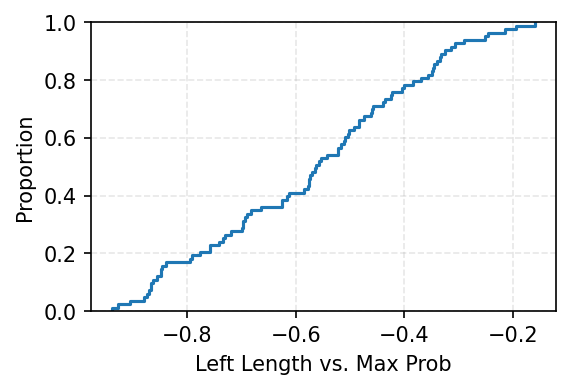

In [11]:
def get_left_count_corr(col):
    col = col[col > 0]
    left_ratio = []
    avg_probs = []
    estimation_length = []
    for i in range(15, len(col)):
        probs = col.iloc[:i].max()
        left_ratio.append((len(col) - i))
        avg_probs.append(probs)
        estimation_length.append(i/probs)
    tmp_df = pd.DataFrame({"left_ratio": left_ratio, "mean": avg_probs, "estimation_length": estimation_length})
    corr = tmp_df.corr(method="pearson").loc["mean", "left_ratio"]
    return col.name, corr

plt.figure(figsize=(4, 2.5), dpi=150)
sns.ecdfplot(
    df_prob.apply(lambda col: get_left_count_corr(col), axis=0).T[1]
)
plt.xlabel("Left Length vs. Max Prob")
plt.grid(alpha=0.3, linestyle="--")

In [12]:
from scipy.stats import spearmanr


def get_left_count(col, start):
    col = col[col > 0]
    left_ratio = []
    avg_probs = []
    estimation_length = []
    for i in range(start, len(col)):
        probs = col.iloc[:i].mean()
        left_ratio.append((len(col) - i))
        avg_probs.append(probs)
        estimation_length.append(i / probs)
    tmp_df = pd.DataFrame(
        {
            "left_ratio": left_ratio,
            "mean": avg_probs,
            "estimation_length": estimation_length,
        }
    )
    return tmp_df


# 定义不同的起始值范围
start_values = range(1, 21)  # 例如，从1到20

correlations = {}

for start in start_values:
    tmp_dfs = [get_left_count(df_prob[col], start) for col in df_prob]
    true_pred = [
        (tmp_df.loc[:, "left_ratio"][0], tmp_df.loc[:, "estimation_length"][0])
        for tmp_df in tmp_dfs
        if len(tmp_df) > 0
    ]
    true_pred = [x for x in true_pred if x[0] > 0 and x[1] > 0]
    true_length, pred_length = [x[0] for x in true_pred], [x[1] for x in true_pred]
    if len(true_length) > 1 and len(pred_length) > 1:
        corr, _ = spearmanr(true_length, pred_length)
        correlations[start] = corr
    else:
        correlations[start] = None

# 打印不同起始值的相关系数
for start, corr in correlations.items():
    print(f"Start: {start}, Correlation: {corr}")

Start: 1, Correlation: 0.18024103433658664
Start: 2, Correlation: 0.18664467688131495
Start: 3, Correlation: 0.16213807934009886
Start: 4, Correlation: 0.14848447424765865
Start: 5, Correlation: 0.16226363904281782
Start: 6, Correlation: 0.2319575304311669
Start: 7, Correlation: 0.2558072488870452
Start: 8, Correlation: 0.2714270767272871
Start: 9, Correlation: 0.2839502747660044
Start: 10, Correlation: 0.2914753446333335
Start: 11, Correlation: 0.3075080242854516
Start: 12, Correlation: 0.3485506311453071
Start: 13, Correlation: 0.3859031768153894
Start: 14, Correlation: 0.38703081739300144
Start: 15, Correlation: 0.36996995135476746
Start: 16, Correlation: 0.3545766061000128
Start: 17, Correlation: 0.37208316400966407
Start: 18, Correlation: 0.31446564375347225
Start: 19, Correlation: 0.29616388941406574
Start: 20, Correlation: 0.2633428615094942


In [13]:
from scipy.stats import spearmanr


def get_left_count(col, start, n):
    col = col[col > 0]
    left_ratio = []
    gittins_index = []
    for i in range(start, len(col)):
        probs = col.iloc[:i].max()
        left_ratio.append((len(col) - i))
        gittins_index.append((1-(1-probs)**n)/np.sum(np.arange(1, n)*(1-probs)**np.arange(1,n)))
    tmp_df = pd.DataFrame(
        {
            "left_ratio": left_ratio,
            "estimation_length": gittins_index,
        }
    )
    return tmp_df


# 定义不同的起始值范围
start_values = range(15, 16)  # 例如，从1到20
n_values=range(3,15)
correlations = {}
for n in n_values:
    for start in start_values:
        correlations[n] = []
        tmp_dfs = [get_left_count(df_prob[col], start, n) for col in df_prob]
        for i in range(0, len(df_prob)):
            true_pred = [
                (tmp_df.loc[:, "left_ratio"][i], tmp_df.loc[:, "estimation_length"][i])
                for tmp_df in tmp_dfs
                if len(tmp_df) > i
            ]
            true_pred = [x for x in true_pred if x[0] > 0 and x[1] > 0]
            true_length, pred_length = [x[0] for x in true_pred], [x[1] for x in true_pred]
            if len(true_length) > 1 and len(pred_length) > 1:
                corr, _ = spearmanr(true_length, pred_length)
                correlations[n].append(corr)
            else:
                correlations[n].append(None) 

# # 打印不同起始值的相关系数
# for start, corr in correlations.items():
#     print(f"Start: {start}, Correlation: {corr}")

In [14]:
tmp_dfs

[     left_ratio  estimation_length
 0           175           0.002024
 1           174           0.002024
 2           173           0.002024
 3           172           0.002024
 4           171           0.002024
 ..          ...                ...
 170           5           0.060905
 171           4           0.060905
 172           3           0.060905
 173           2           0.060905
 174           1           0.104617
 
 [175 rows x 2 columns],
     left_ratio  estimation_length
 0           89           0.000133
 1           88           0.000133
 2           87           0.000133
 3           86           0.000133
 4           85           0.000133
 ..         ...                ...
 84           5           0.221611
 85           4           0.221611
 86           3           0.221611
 87           2           0.221611
 88           1           0.221611
 
 [89 rows x 2 columns],
      left_ratio  estimation_length
 0           611           0.000005
 1           610       

In [15]:
for n in correlations:
    corrs = [i for i in correlations[n] if i is not None]
    print(corrs)
    print(n,np.mean(corrs))

[-0.36070954409574435, -0.3447809298112107, -0.35360500408963585, -0.3091310158822388, -0.2925779180842668, -0.26403838387245976, -0.26403838387245976, -0.2644460455551652, -0.2631698072641129, -0.2631698072641129, -0.2631698072641129, -0.27233806520063425, -0.27233806520063425, -0.2509854200907798, -0.23586425345826353, -0.2258735116798589, -0.22907196078438558, -0.22907196078438558, -0.22907196078438558, -0.28091596439849587, -0.2810604610624527, -0.2810604610624527, -0.2824765283692297, -0.31417187160816296, -0.30413196016943006, -0.2816453136058777, -0.28216934789939563, -0.25867897262973, -0.259969022918057, -0.259969022918057, -0.2596266021625135, -0.2596266021625135, -0.24054691460171176, -0.24054691460171176, -0.24054691460171176, -0.24054691460171176, -0.22675880694454018, -0.22675880694454018, -0.22675880694454018, -0.22300514897936397, -0.22300514897936397, -0.20948045591623984, -0.20948045591623984, -0.20948045591623984, -0.20948045591623984, -0.24742862087120157, -0.253503

In [16]:
from scipy.stats import spearmanr
def get_left_count(col, start):
    col = col[col >0]
    left_ratio = []
    estimation_length = []
    for i in range(start, start+2):
        mean_probs = col.iloc[:i].mean()
        max_probs = col.iloc[:i].max()
        left_ratio.append((len(col) - i))
        estimation_length.append(mean_probs/max_probs)
    tmp_df = pd.DataFrame({"left_ratio": left_ratio,  "estimation_length": estimation_length})
    return tmp_df

# 定义不同的起始值范围
start_values = range(2, 40)  # 例如，从1到20

probs_correlations = {}

for start in start_values:
    tmp_dfs = [get_left_count(df_prob[col], start) for col in df_prob]
    true_pred = [(tmp_df.loc[:, 'left_ratio'][0],tmp_df.loc[:, 'estimation_length'][0]) for tmp_df in tmp_dfs if len(tmp_df) > 0]
    true_pred = [x for x in true_pred if x[0] > 0 and x[1] > 0]
    true_length,pred_length = [x[0] for x in true_pred], [x[1] for x in true_pred]
    if len(true_length) > 1 and len(pred_length) > 1:
        corr, _ = spearmanr(true_length, pred_length)
        probs_correlations[start] = corr
    else:
        probs_correlations[start] = None

# 打印不同起始值的相关系数
for start, corr in probs_correlations.items():
    print(f"Start: {start}, Correlation: {corr}")

Start: 2, Correlation: 0.2197439728195319
Start: 3, Correlation: 0.2671910473859669
Start: 4, Correlation: 0.2219774034681651
Start: 5, Correlation: 0.19215494891591442
Start: 6, Correlation: 0.19606701518919525
Start: 7, Correlation: 0.18185118679959988
Start: 8, Correlation: 0.0954488085167855
Start: 9, Correlation: 0.09362072913050616
Start: 10, Correlation: 0.039765784260302604
Start: 11, Correlation: 0.05133616637377694
Start: 12, Correlation: 0.05822486562222393
Start: 13, Correlation: 0.09557302358577857
Start: 14, Correlation: 0.08124277406639777
Start: 15, Correlation: 0.09170688610311017
Start: 16, Correlation: 0.06224934496866967
Start: 17, Correlation: 0.04779836469130279
Start: 18, Correlation: 0.06448498170747052
Start: 19, Correlation: 0.07461895624702537
Start: 20, Correlation: 0.09771806466997852
Start: 21, Correlation: 0.06692282248534204
Start: 22, Correlation: 0.07297003955812428
Start: 23, Correlation: 0.060454396212862326
Start: 24, Correlation: 0.0618315476136193

[-0.07710611424557898, -0.04152596838481321, -0.048359365365503684, -0.041276507471660465, -0.044260518994845864, -0.04140289618853766, -0.04161673652484211, -0.040971040088889805, -0.040378149426496916, -0.03993497918458467, -0.050739714006287406, -0.059188848483327464, -0.07436464384047974, -0.07494438502354474, -0.07523229020141597, -0.07533259121211479, -0.12579329576959455, -0.10939978987032448, -0.10913796850476633, -0.03186773146450989, -0.03757356813266126, 0.007375218963280585, -0.028371155939670368, -0.02844746780733278, -0.033827779482426656, -0.11628417723323528, -0.11668121610593203, -0.11827897365833537, -0.11716597573419123]


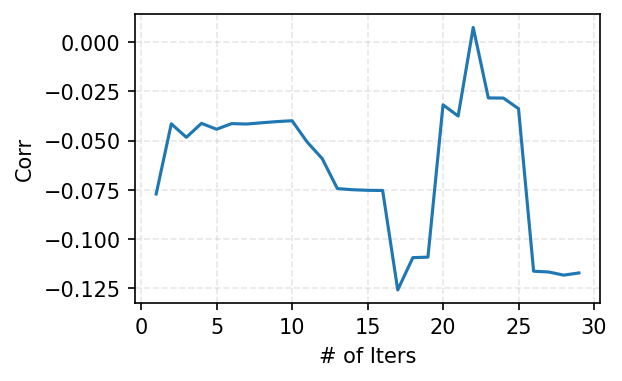

In [17]:
left_count_corr = df_prob.apply(lambda col: get_left_count_corr(col), axis=0).T
left_count_corr["index"] = left_count_corr[0].apply(lambda x: int(x))
left_count_corr["left_count_corr"] = left_count_corr[1]
count = df.describe().T["count"]
corrs = []
for i in range(1, 30):
    df_eos_prob_count = df_prob[:i].describe().T[["count", "max"]]
    df_eos_prob_count["count"] = count - i

    df_eos_prob_count = df_eos_prob_count[
        df_eos_prob_count["count"] > 0
    ].reset_index()
    df_eos_prob_count = pd.merge(df_eos_prob_count, left_count_corr, on="index")
    # df_eos_prob_count["left_count_corr"] = left_count_corr
    corrs.append(
        df_eos_prob_count[["max", "left_count_corr"]]
        .corr(method="pearson")
        .loc["max", "left_count_corr"]
    )
print(corrs)
plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(range(1, 30), corrs)
plt.xlabel("# of Iters")
plt.ylabel("Corr")
plt.grid(alpha=0.3, linestyle="--")

In [7]:
df_eos_prob_count[["mean", "left_count_corr"]]

,mean,left_count_corr
0,0.000019,-0.379282
1,0.000006,-0.355833
2,0.000041,-0.344402
3,0.000431,NaN
4,0.000081,NaN
...,...,...
112,0.000085,-0.525378
113,0.000776,-0.598334
114,0.000082,-0.515208
115,0.000021,-0.551068


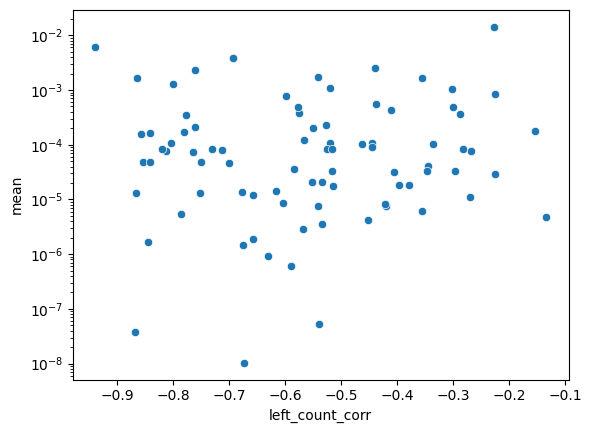

In [8]:
sns.scatterplot(df_eos_prob_count, x="left_count_corr", y="mean")
plt.yscale("log")

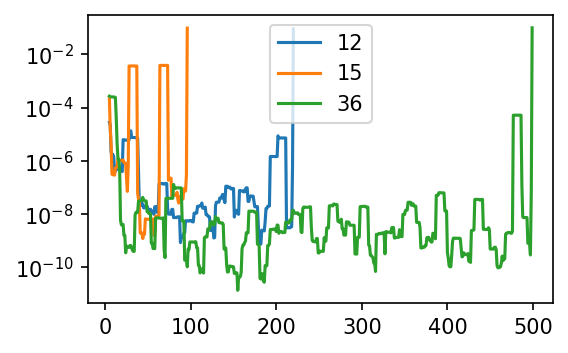

In [11]:
plt.figure(figsize=(4, 2.5), dpi=150)
rolling_mean_df_prob = df_prob.rolling(window=10, center=True).mean()
data = rolling_mean_df_prob.loc[:, [12,15,36]]
sns.lineplot(data=data, dashes=False)
plt.yscale("log")
# plt.ylim(0,50)

# EoS Position Analysis

In [49]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
count,331.000000,423.000000,206.000000,499.000000,249.000000,99.000000,644.000000,1.0,1.0,827.000000,...,15.000000,1.0,1.0,160.000000,497.000000,29.000000,625.000000,496.000000,362.000000,36.000000
mean,0.027017,0.009274,0.053500,0.077768,0.036042,0.010693,0.226027,0.0,0.0,0.048540,...,0.015012,0.0,0.0,0.025006,0.245185,0.121578,0.007161,0.038723,0.045509,0.008564
std,0.057358,0.023156,0.115165,0.160499,0.072219,0.011944,0.322290,NaN,NaN,0.116780,...,0.020717,NaN,NaN,0.071699,0.323296,0.206290,0.025234,0.100200,0.089166,0.023996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004844,0.001781,0.002664,0.004000,0.004281,0.001828,0.003500,0.0,0.0,0.005078,...,0.001016,0.0,0.0,0.000766,0.007281,0.002375,0.000750,0.004094,0.003594,0.000328
50%,0.011687,0.004250,0.009172,0.016344,0.013344,0.004812,0.024328,0.0,0.0,0.016719,...,0.007031,0.0,0.0,0.005000,0.074844,0.033500,0.002125,0.012766,0.013813,0.003438
75%,0.028797,0.010000,0.050891,0.070828,0.039938,0.018406,0.383836,0.0,0.0,0.044953,...,0.018547,0.0,0.0,0.022187,0.375000,0.134875,0.006844,0.032625,0.046289,0.006500
max,0.623687,0.308312,0.920250,0.987969,0.785594,0.053812,0.996594,0.0,0.0,0.983469,...,0.081219,0.0,0.0,0.796094,0.990125,0.807719,0.577562,0.949688,0.878031,0.144469


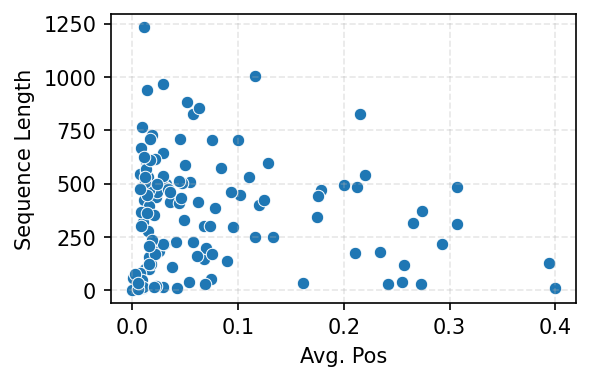

In [107]:
output = df.describe().T[["count"]]
pos_mean= df[:20].describe().T[["std"]]
# output=output//10*10
count_pos_mean = pd.DataFrame({"mean": pos_mean.values.flatten(), "count": output.values.flatten()})
plt.figure(figsize=(4,2.5), dpi=150)
sns.scatterplot(data=count_pos_mean, x="mean",y="count")
# plt.xlim(0,0.001)
plt.xlabel("Avg. Pos")
plt.ylabel("Sequence Length")
plt.grid(alpha=0.3, linestyle='--')

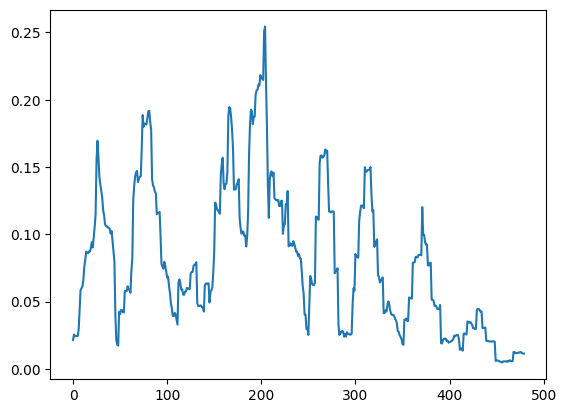

In [91]:
mov_avg = np.convolve(df[3], np.ones(20)/20, mode='valid')
plt.plot(mov_avg)
# plt.yscale('log')
# plt.ylim(1e-100)